#### Predicting the outcome of a shot given its features

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [10]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id,season_id)).json()
    match_ids = [m['match_id'] for m in matches]
    
    all_events = []
    
    for match_id in tqdm(match_ids):
        events = requests.get(url=match_url.format(match_id)).json()
        
        shots = [x for x in events if x['type']['name'] == "Shot"]
        for s in shots:
            attributes = {
                "x" : s['location'][0],
                "y" : s['location'][1],
                "head" : 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase" : s['shot']['type']['name'],
                "outcome" : 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "xG" : s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [11]:
competition_id = 43
season_id = 3

In [12]:
df = parse_data(competition_id,season_id)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:12<00:00,  1.14s/it]


In [13]:
def distance_to_goal(origin):
    dest = np.array([120.,40.])
    return np.sqrt(np.sum((origin-dest)**2))

In [14]:
def goal_angle(origin):
    leftPost = np.array((120.,36.))
    originA = np.array(origin,dtype=np.float)
    rightPost = np.array((120.,44.))
    
    v0 = leftPost - originA
    v1 = rightPost - leftPost
    
    angle = np.abs(np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1)))
    
    return angle

In [15]:
df['distance_to_goal'] = df.apply(
    lambda row: distance_to_goal(row[['x','y']]),axis=1)
df['goal_angle'] = df.apply(
    lambda r: goal_angle(r[['x','y']]),axis=1)

In [16]:
df.head()

,x,y,head,phase,outcome,xG,distance_to_goal,goal_angle
0,115.0,34.0,0,Open Play,1,0.074087,7.810250,1.190290
1,112.0,36.0,0,Open Play,1,0.292995,8.944272,1.570796
2,101.0,55.0,0,Free Kick,0,0.078714,24.207437,2.356194
3,103.0,24.0,0,Open Play,0,0.028038,23.345235,0.956133
4,96.0,37.0,0,Open Play,0,0.064261,24.186773,1.612439


In [17]:
shots = df[~df['phase'].isin(['Free Kick','Penalty'])]

In [19]:
shots.head()

,x,y,head,phase,outcome,xG,distance_to_goal,goal_angle
0,115.0,34.0,0,Open Play,1,0.074087,7.810250,1.190290
1,112.0,36.0,0,Open Play,1,0.292995,8.944272,1.570796
3,103.0,24.0,0,Open Play,0,0.028038,23.345235,0.956133
4,96.0,37.0,0,Open Play,0,0.064261,24.186773,1.612439
5,111.0,50.0,0,Open Play,0,0.303150,13.453624,2.570255


In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [25]:
features = shots[['distance_to_goal','goal_angle','head']]
labels = shots['outcome']

fit = model.fit(features,labels)

In [26]:
predictions = model.predict_proba(features)[:,1]

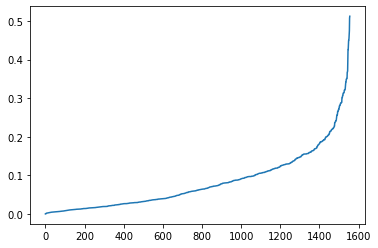

In [27]:
plt.plot(sorted(predictions))
plt.show()